In [3]:
import re
import numpy as np
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# import umap.umap_ as umap

import openpyxl
from openpyxl.drawing.line import LineProperties
from openpyxl.chart.shapes import GraphicalProperties
from openpyxl.chart.text import RichText
from openpyxl.drawing.text import Paragraph, ParagraphProperties, CharacterProperties, Font

In [3]:
# 各フォルダの読み込み
folder_list = glob.glob(r'.\input\spectra_data\*')

# データの区切りを指定（タブ：'\t', コンマ：',', セミコロン：';'）
sep = '[,;\t]'

# excelファイルの保存先のパス
output_path = r'.\output\\'

In [82]:
label_list = ['CH3:COOH=1:0', 'CH3:COOH=3:1', 'CH3:COOH=1:1', 'CH3:COOH=1:3', 'CH3:COOH=0:1']
# label_list = ['CH3:OH=1:0', 'CH3:OH=3:1', 'CH3:OH=1:1', 'CH3:OH=1:3', 'CH3:OH=0:1']
# label_list = ['CH3:NH2=1:0', 'CH3:NH2=3:1', 'CH3:NH2=1:1', 'CH3:NH2=1:3', 'CH3:NH2=0:1']
# label_list = ['CH3:COOH=0:1', 'CH3:COOH=1:3', 'CH3:COOH=1:1', 'CH3:COOH=3:1', 'CH3:COOH=1:0', 'CH3:NH2=3:1', 'CH3:NH2=1:1', 'CH3:NH2=1:3', 'CH3:NH2=0:1']

# データフレームの読み込み
dataframe_path = r'.\input\dataframe\\'
# excelファイルの保存先のパス
output_path = r'.\output\\'

dataframe_title = '1variable_analysis_data'

data_df = pd.read_excel(dataframe_path + dataframe_title + '.xlsx')
data_df.head()

,Index,raw_peak1,raw_peak2,raw_peak3,raw_peak4,raw_peak5,std_peak1,std_peak2,std_peak3,std_peak4,std_peak5,label
0,CH3-COOH_1-0_01,5103.738329,-190.438947,3683.338417,15008.388339,2495.599180,0.985504,-1.281596,1.603149,2.807891,-1.408493,0
1,CH3-COOH_1-0_02,7812.295705,-194.556679,4414.272363,13674.507873,2396.694976,2.357140,-1.341189,2.553350,3.504776,-1.522716,0
2,CH3-COOH_1-0_03,6766.516954,-197.440682,4061.869953,15787.879885,2984.004149,1.827549,-1.262702,2.205239,4.876685,-0.896542,0
3,CH3-COOH_1-0_04,6495.640211,-140.306765,3963.427044,16377.685418,2759.395509,1.690375,-1.186554,1.991127,2.524528,-1.136014,0
4,CH3-COOH_1-0_05,7921.366032,-250.325583,4436.995675,15268.477283,2591.922039,2.412374,-1.365968,2.478621,3.846731,-1.314570,0


In [83]:
# 特徴量とラベルの分離
data_label = data_df['label']
data_df = data_df.drop(['Index', 'label'], axis=1)

In [157]:
analysis_data_df = data_df[['std_peak5']]

# Linear SVC

## クロスバリデーションでの予測

In [158]:
# kernel:rbf(ガウス関数) その他：linear(線形回帰)、poly(多項式展開)、sigmoidなどがある
def linear_svc(C, data_df, label):
    # SVM処理
    # 特徴量とラベルの分割
    X = data_df
    y = label
    oof = np.zeros(len(y))

    kf = KFold(n_splits=5, shuffle=True, random_state=1234)
    for train_idx, val_idx in kf.split(X):
        train_x, val_x = X.iloc[train_idx], X.iloc[val_idx]
        train_y, val_y = y.iloc[train_idx], y.iloc[val_idx]

        svm_model = LinearSVC(C=C, max_iter=5000)
        svm_model.fit(train_x, train_y)
        y_pred = svm_model.predict(val_x)
        oof[val_idx] = y_pred

    cm = confusion_matrix(y, oof)
    # 正解率
    Accuracy = accuracy_score(y, oof)

    return cm, Accuracy

c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\west7\anaconda3\envs\xeus-python\lib\site-pack

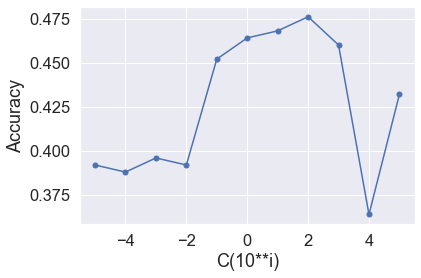

In [159]:
# Cの決定
temp_accuracy_dict = {}

for i in range(-5, 6, 1):
    _, accuracy_svm = linear_svc(10**i, analysis_data_df, data_label)
    temp_accuracy_dict[i] = accuracy_svm

temp_accuracy_list = temp_accuracy_dict.items()
x, y = zip(*temp_accuracy_list)

plt.plot(x, y, marker='o', markersize=5)
plt.xlabel('C(10**i)')
plt.ylabel('Accuracy')
plt.show()

In [160]:
cm_linear_svc, accuracy_linear_svc = linear_svc(100, analysis_data_df, data_label)
print('Accuracy:', accuracy_linear_svc)

c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy: 0.472


<AxesSubplot:>

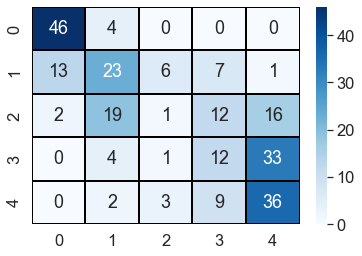

In [161]:
sns.set(font_scale=1.5)
sns.heatmap(cm_linear_svc, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

## 学習データでの予測

In [100]:
def train_linear_svc(C, data_df, label):
    # SVM処理
    # 特徴量とラベルの分割
    X = data_df
    X.columns = [str(i) for i in data_df.columns]
    y = label

    svm_model = LinearSVC(C=C, max_iter=5000)
    svm_model.fit(X, y)
    y_pred = svm_model.predict(X)

    cm = confusion_matrix(y, y_pred)
    # 正解率
    Accuracy = accuracy_score(y, y_pred)

    return cm, Accuracy

In [109]:
train_cm_linear_svc, train_accuracy_linear_svc = train_linear_svc(0.1, analysis_data_df, data_label)
print('Accuracy:', train_accuracy_linear_svc)

Accuracy: 0.4


c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


<AxesSubplot:>

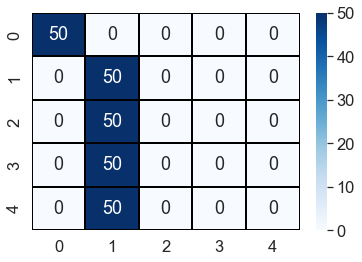

In [110]:
sns.set(font_scale=1.5)
sns.heatmap(train_cm_linear_svc, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

# Perceptron

## クロスバリデーションでの予測

In [103]:
def perceptron(data_df, label):
    # SVM処理
    # 特徴量とラベルの分割
    X = data_df
    X.columns = [str(i) for i in data_df.columns]
    y = label
    oof = np.zeros(len(y))

    kf = KFold(n_splits=5, shuffle=True, random_state=1234)
    for train_idx, val_idx in kf.split(X):
        train_x, val_x = X.iloc[train_idx], X.iloc[val_idx]
        train_y, val_y = y.iloc[train_idx], y.iloc[val_idx]

        per_model = Perceptron()
        per_model.fit(train_x, train_y)
        y_pred = per_model.predict(val_x)
        oof[val_idx] = y_pred

    cm = confusion_matrix(y, oof)
    # 正解率
    Accuracy = accuracy_score(y, oof)

    return cm, Accuracy

In [104]:
cm_per, accuracy_per = perceptron(analysis_data_df, data_label)
print('Accuracy:', accuracy_per)

Accuracy: 0.224


<AxesSubplot:>

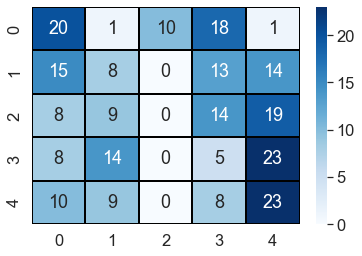

In [105]:
sns.set(font_scale=1.5)
sns.heatmap(cm_per, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

# Logistic Regression

In [106]:
def logistic(data_df, label):
    # 特徴量とラベルの分割
    X = data_df
    X.columns = [str(i) for i in data_df.columns]
    y = label
    oof = np.zeros(len(y))

    kf = KFold(n_splits=5, shuffle=True, random_state=1234)
    for train_idx, val_idx in kf.split(X):
        train_x, val_x = X.iloc[train_idx], X.iloc[val_idx]
        train_y, val_y = y.iloc[train_idx], y.iloc[val_idx]

        log_model = LogisticRegression()
        log_model.fit(train_x, train_y)
        y_pred = log_model.predict(val_x)
        oof[val_idx] = y_pred

    cm = confusion_matrix(y, oof)
    # 正解率
    Accuracy = accuracy_score(y, oof)

    return cm, Accuracy

In [107]:
cm_log, accuracy_log = perceptron(analysis_data_df, data_label)
print('Accuracy:', accuracy_log)

Accuracy: 0.224


<AxesSubplot:>

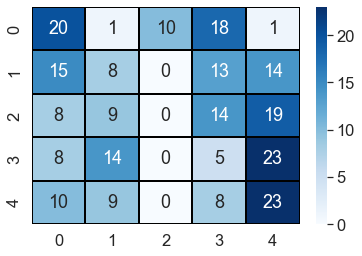

In [108]:
sns.set(font_scale=1.5)
sns.heatmap(cm_log, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

# スペクトルの2次元可視化

## データの読み込み

In [45]:
# label_list = ['CH3:COOH=1:0', 'CH3:COOH=3:1', 'CH3:COOH=1:1', 'CH3:COOH=1:3', 'CH3:COOH=0:1']
# label_list = ['CH3:OH=1:0', 'CH3:OH=3:1', 'CH3:OH=1:1', 'CH3:OH=1:3', 'CH3:OH=0:1']
# label_list = ['CH3:NH2=1:0', 'CH3:NH2=3:1', 'CH3:NH2=1:1', 'CH3:NH2=1:3', 'CH3:NH2=0:1']
CH3_SH_label_list = ['CH3:SH=1:0', 'CH3:SH=3:1', 'CH3:SH=1:1', 'CH3:SH=1:3', 'CH3:SH=0:1']

CH3_COOH_OH_NH2_label_list = ['CH3:COOH=1:0', 'CH3:COOH=3:1', 'CH3:COOH=1:1', 'CH3:COOH=1:3', 'CH3:COOH=0:1',
                             'CH3:OH=3:1', 'CH3:OH=1:1', 'CH3:OH=1:3', 'CH3:OH=0:1',
                             'CH3:NH2=3:1', 'CH3:NH2=1:1', 'CH3:NH2=1:3', 'CH3:NH2=0:1']

CH3_COOH_OH_NH2_SH_label_list = ['CH3:COOH=1:0', 'CH3:COOH=3:1', 'CH3:COOH=1:1', 'CH3:COOH=1:3', 'CH3:COOH=0:1',
                                 'CH3:OH=3:1', 'CH3:OH=1:1', 'CH3:OH=1:3', 'CH3:OH=0:1',
                                 'CH3:NH2=3:1', 'CH3:NH2=1:1', 'CH3:NH2=1:3', 'CH3:NH2=0:1',
                                 'CH3:SH=3:1', 'CH3:SH=1:1', 'CH3:SH=1:3', 'CH3:SH=0:1']

# データフレームの読み込み
dataframe_path = r'.\input\dataframe\\'
# excelファイルの保存先のパス
output_path = r'.\output\\'

# pickleファイルの読み込み
all_title = 'CH3_COOH_OH_NH2_SH_standard_df'
ch3_cooh_oh_nh2_title = "CH3_COOH_OH_NH2_standard_df"
ch3_sh_title = 'CH3_SH_standard_df'

all_df = pd.read_pickle(dataframe_path + all_title + '.pkl')
ch3_cooh_oh_nh2_df = pd.read_pickle(dataframe_path + ch3_cooh_oh_nh2_title + '.pkl')
ch3_sh_df = pd.read_pickle(dataframe_path + ch3_sh_title + '.pkl')

# 特徴量とラベルの分離
all_label = all_df['label']
ch3_cooh_oh_nh2_label = ch3_cooh_oh_nh2_df['label']
ch3_sh_label = ch3_sh_df["label"]
all_df = all_df.drop('label', axis=1)
ch3_cooh_oh_nh2_df = ch3_cooh_oh_nh2_df.drop('label', axis=1)
ch3_sh_df = ch3_sh_df.drop('label', axis=1)

## 前処理

Raman Shift,199.147424,201.192791,203.237476,205.281480,207.324801,209.367441,211.409400,213.450678,215.491276,217.531194,...,1735.286945,1736.849012,1738.410618,1739.971761,1741.532444,1743.092665,1744.652426,1746.211725,1747.770565,1749.328943
CH3-COOH_1-0_01,-0.255826,-0.329458,-0.243873,-0.323636,-0.339238,-0.418278,-0.362079,-0.320504,-0.263580,-0.275232,...,-0.228963,-0.209584,-0.226174,-0.225639,-0.210549,-0.185184,-0.224050,-0.199547,-0.215296,-0.195079
CH3-COOH_1-0_02,-0.335234,-0.394590,-0.428526,-0.446909,-0.425066,-0.418104,-0.471261,-0.382197,-0.317061,-0.399231,...,-0.217711,-0.232014,-0.272639,-0.222789,-0.217358,-0.249764,-0.249271,-0.241378,-0.219504,-0.259321
CH3-COOH_1-0_03,-0.351962,-0.466334,-0.471799,-0.476556,-0.493150,-0.488650,-0.419933,-0.423423,-0.328197,-0.377310,...,-0.258174,-0.263040,-0.253794,-0.226517,-0.254124,-0.275460,-0.241131,-0.227972,-0.241471,-0.239291
CH3-COOH_1-0_04,-0.340418,-0.305730,-0.410646,-0.369136,-0.407863,-0.415038,-0.330525,-0.370193,-0.338219,-0.343306,...,-0.252784,-0.222816,-0.259152,-0.236897,-0.247796,-0.240964,-0.248012,-0.234246,-0.224337,-0.246040
CH3-COOH_1-0_05,-0.223680,-0.361366,-0.423412,-0.405274,-0.327401,-0.456380,-0.439284,-0.332157,-0.366749,-0.355235,...,-0.210957,-0.217217,-0.220450,-0.215355,-0.219351,-0.229408,-0.245527,-0.213935,-0.204309,-0.226495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CH3-SH_0-1_46,-0.841421,-0.803090,-0.707791,-0.803811,-0.722997,-0.636583,-0.624477,-0.723779,-0.623414,-0.811398,...,-0.054829,-0.143301,-0.154724,-0.034874,-0.140490,-0.177619,-0.089183,-0.163428,-0.177748,-0.115019
CH3-SH_0-1_47,-0.703034,-0.496107,-0.713924,-0.751378,-0.746475,-0.685061,-0.867919,-0.633323,-0.657152,-0.652776,...,-0.132729,0.004924,-0.129904,-0.130270,-0.088180,-0.138101,-0.145565,-0.057494,-0.121590,0.033702
CH3-SH_0-1_48,-0.797512,-0.820236,-0.800051,-0.868487,-0.684073,-0.722337,-0.803690,-0.561370,-0.617607,-0.527228,...,-0.082957,-0.024863,-0.128658,-0.121167,-0.106095,-0.040441,-0.134147,-0.114038,-0.091406,-0.121899
CH3-SH_0-1_49,-0.646984,-0.595498,-0.821033,-0.707852,-0.783729,-0.944412,-0.583937,-0.787173,-0.768973,-0.646622,...,-0.117589,-0.183139,-0.043450,-0.177427,-0.109422,0.004186,-0.256866,-0.117206,-0.199087,-0.056182


## PCA

In [46]:
def pca_2d_plot(df, df_label, label_list):
    pca = PCA(n_components=2)

    pca_X = pca.fit_transform(df.values)
    pca_result_df = pd.DataFrame(pca_X)
    pca_result_df.columns = ['PC1', 'PC2']
    pca_result_df['label'] = df_label.values

    color_list = ['red', 'orange', 'green', 'blue', 'purple', 'cyan', 'gold', 'grey', 'black', 'lime',
                  'navy', 'pink', 'brown', 'darkorange', 'darkcyan', 'lightsalmon', 'darkviolet']

    for i in range(np.unique(df_label).size):
        data = pca_result_df[pca_result_df['label'] == i]
        plt.scatter(data['PC1'], data['PC2'], c=color_list[i], label=label_list[i])

    # 寄与率の算出
    exp_var_ratio = pd.DataFrame([pca.explained_variance_ratio_], columns=['PC1', 'PC2'])
    print(exp_var_ratio)

    #各主成分の固有ベクトル
    pca_vec_df = pd.DataFrame(pca.components_, columns=df.columns, index=['PC1', 'PC2'])

    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend(loc='best')
    plt.show()

    return pca_result_df, pca_vec_df

        PC1      PC2
0  0.686831  0.10816


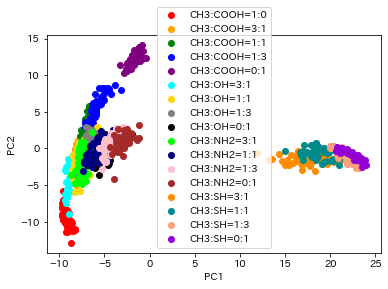

In [47]:
standard_pca_result_df, standard_pca_vec_df = pca_2d_plot(all_df, all_label, CH3_COOH_OH_NH2_SH_label_list)

In [ ]:
# 固有ベクトルの可視化
standard_pca_vec_df.T.plot()

## tSNE

In [ ]:
# tSNEのパラメータ検討
def create_2d_tsne(target_X, y, y_labels, perplexity_list=[5, 10, 20, 30, 40, 50, 100]):
    """
    params target_X: 特徴量データ
    params y: ラベルデータ
    params y_labels: ラベルのリスト（ラベルのユニーク）
    """
    fig, axes = plt.subplots(nrows=1, ncols=len(perplexity_list), figsize=(5*len(perplexity_list), 4))
    for ax, perplexity in zip(axes.flatten(), perplexity_list):

        tsne = TSNE(n_components=2, random_state=0, perplexity=perplexity)
        Y = tsne.fit_transform(target_X)
        for each_label in y_labels:
            c_plot_bool = y == y_labels.index(each_label)
            ax.scatter(Y[c_plot_bool, 0], Y[c_plot_bool, 1], label="{}".format(each_label))

        ax.legend()
        ax.set_title("perplexity: {}".format(perplexity))

    plt.show()

In [ ]:
create_2d_tsne(std_data_df, std_data_label, label_list)

In [50]:
def tsne_2D_plot(df, df_label, label_list, perplexity=30):
    tsne = TSNE(n_components=2, random_state=0, perplexity=perplexity, init='pca')

    X = tsne.fit_transform(df.values)
    tsne_result_df = pd.DataFrame(X)
    tsne_result_df.columns = ['tSNE1', 'tSNE2']
    tsne_result_df['label'] = df_label.values

    color_list = ['red', 'orange', 'green', 'blue', 'purple', 'cyan', 'gold', 'grey', 'black', 'lime',
                  'navy', 'pink', 'brown', 'darkorange', 'darkcyan', 'lightsalmon', 'darkviolet']

    for i in range(np.unique(df_label).size):
        data = tsne_result_df[tsne_result_df['label'] == i]
        plt.scatter(data['tSNE1'], data['tSNE2'], c=color_list[i], label=label_list[i])

    plt.xlabel('tSNE1')
    plt.ylabel('tSNE2')
    plt.legend(loc='best')
    plt.show()

    return tsne_result_df

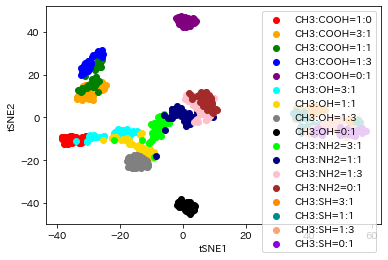

In [51]:
standard_tsne_result_df = tsne_2D_plot(all_df, all_label, CH3_COOH_OH_NH2_SH_label_list)

## LDA

In [52]:
def lda_2D_plot(df, df_label, label_list):
    lda = LDA(n_components=2)
    X_r2 = lda.fit(df, df_label).transform(df)

    color_list = ['red', 'orange', 'green', 'blue', 'purple', 'cyan', 'gold', 'grey', 'black', 'lime',
                  'navy', 'pink', 'brown', 'darkorange', 'darkcyan', 'lightsalmon', 'darkviolet']

    # Percentage of variance explained for each components
    print('explained variance ratio (first two components): %s' % str(lda.explained_variance_ratio_))

    for i in range(np.unique(df_label).size):
        plt.scatter(X_r2[df_label == i, 0], X_r2[df_label == i, 1],
        c=color_list[i], label=label_list[i])

    # ldaの結果をデータフレーム化
    lda_result_df = pd.DataFrame(X_r2)
    lda_result_df.columns = ['LDA1', 'LDA2']
    lda_result_df['label'] = df_label.values

    # 重みベクトルの取得
    lda_weight_vec_df = pd.DataFrame(lda.coef_, columns=df.columns, index=label_list)

    plt.xlabel('LDA1')
    plt.ylabel('LDA2')
    plt.legend(loc='best')
    plt.show()

    return lda_result_df, lda_weight_vec_df

explained variance ratio (first two components): [0.71707565 0.14100996]


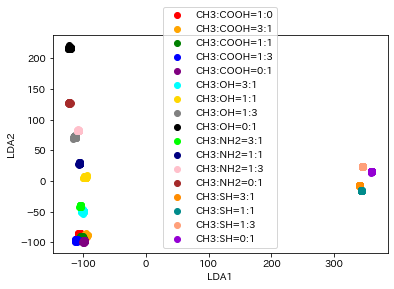

In [53]:
standard_lda_result_df, standard_lda_weight_vec_df = lda_2D_plot(all_df, all_label, CH3_COOH_OH_NH2_SH_label_list)

### 異常値検出

In [54]:
def lda_2D_plot(df, df_label, test_df, test_data_label, label_list):
    lda = LDA(n_components=2)
    X_r2 = lda.fit(df, df_label).transform(test_df)

    color_list = ['red', 'orange', 'green', 'blue', 'purple', 'cyan', 'gold', 'grey', 'black', 'lime',
                  'navy', 'pink', 'brown', 'darkorange', 'darkcyan', 'lightsalmon', 'darkviolet']

    # Percentage of variance explained for each components
    print('explained variance ratio (first two components): %s' % str(lda.explained_variance_ratio_))

    for i in range(np.unique(test_data_label).size):
        plt.scatter(X_r2[test_data_label == i, 0], X_r2[test_data_label == i, 1],
        c=color_list[i], label=label_list[i])

    # ldaの結果をデータフレーム化
    lda_result_df = pd.DataFrame(X_r2)
    lda_result_df.columns = ['LDA1', 'LDA2']
    lda_result_df['label'] = test_data_label.values

    plt.xlabel('LDA1')
    plt.ylabel('LDA2')
    plt.legend(loc='best')
    plt.show()

    return lda_result_df

explained variance ratio (first two components): [0.47067456 0.27250756]


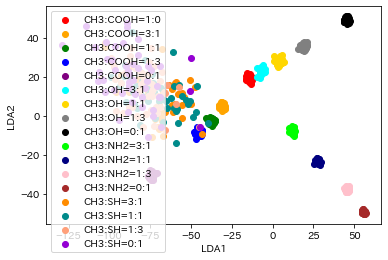

In [55]:
standard_lda_result_df = lda_2D_plot(ch3_cooh_oh_nh2_df, ch3_cooh_oh_nh2_label, all_df, all_label, CH3_COOH_OH_NH2_SH_label_list)

In [30]:
graph_title = 'standard_lda_result_OH'
standard_lda_result_df.to_excel(output_path + graph_title + '.xlsx', index=False)

In [27]:
# データフレームの読み込み
dataframe_path = r'.\input\dataframe\\'
# excelファイルの保存先のパス
output_path = r'.\output\\'

# pickleファイルの読み込み
df_title = 'CH3_COOH_OH_NH2_standard_df'
connect_title = 'CH3_SH_connect_standard_df'

df = pd.read_pickle(dataframe_path + df_title + '.pkl')
connect_df = pd.read_pickle(dataframe_path + connect_title + '.pkl')

In [40]:
a = connect_df[connect_df.label == 0].copy()
a["label"] = 13

b = connect_df[connect_df.label == 1].copy()
b["label"] = 14

c = connect_df[connect_df.label == 2].copy()
c["label"] = 15

d = connect_df[connect_df.label == 3].copy()
d["label"] = 16

In [41]:
temp_df = pd.concat([a, b, c, d])
temp_df

Raman Shift,199.147423618928,201.192791188876,203.237476388369,205.281479548654,207.324801000766,209.367441075527,211.409400103543,213.450678415207,215.491276340697,217.53119420998,...,1736.84901220951,1738.41061757765,1739.97176141826,1741.53244392806,1743.09266530367,1744.65242574159,1746.21172543821,1747.7705645898,1749.32894339254,label
CH3-SH_3-1_01,-0.651816,-0.576817,-0.664302,-0.357886,-0.560028,-0.469429,-0.535988,-0.480180,-0.581529,-0.573822,...,-0.371662,-0.285349,-0.364088,-0.317706,-0.260677,-0.318120,-0.338293,-0.323859,-0.367992,13
CH3-SH_3-1_02,-0.505540,-0.621943,-0.444849,-0.592593,-0.384617,-0.433422,-0.439563,-0.469150,-0.399682,-0.417825,...,-0.312335,-0.271914,-0.287888,-0.257199,-0.304294,-0.258060,-0.254609,-0.130607,-0.286611,13
CH3-SH_3-1_03,-0.511662,-0.665181,-0.818793,-0.762330,-0.687139,-0.671640,-0.634277,-0.741300,-0.644520,-0.579199,...,-0.354729,-0.237941,-0.303095,-0.239642,-0.154233,-0.216262,-0.243788,-0.217992,-0.270621,13
CH3-SH_3-1_04,-0.452961,-0.585494,-0.467671,-0.497043,-0.588799,-0.526935,-0.490349,-0.404831,-0.583120,-0.565381,...,-0.305825,-0.364253,-0.307395,-0.286320,-0.250674,-0.335621,-0.323836,-0.289528,-0.314857,13
CH3-SH_3-1_05,-0.577436,-0.613385,-0.734301,-0.640060,-0.643835,-0.669506,-0.751869,-0.664743,-0.638657,-0.623590,...,-0.201031,-0.275474,-0.188987,-0.211248,-0.190021,-0.238397,-0.230234,-0.226430,-0.263955,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CH3-SH_0-1_46,-0.841421,-0.803090,-0.707791,-0.803811,-0.722997,-0.636583,-0.624477,-0.723779,-0.623414,-0.811398,...,-0.143301,-0.154724,-0.034874,-0.140490,-0.177619,-0.089183,-0.163428,-0.177748,-0.115019,16
CH3-SH_0-1_47,-0.703034,-0.496107,-0.713924,-0.751378,-0.746475,-0.685061,-0.867919,-0.633323,-0.657152,-0.652776,...,0.004924,-0.129904,-0.130270,-0.088180,-0.138101,-0.145565,-0.057494,-0.121590,0.033702,16
CH3-SH_0-1_48,-0.797512,-0.820236,-0.800051,-0.868487,-0.684073,-0.722337,-0.803690,-0.561370,-0.617607,-0.527228,...,-0.024863,-0.128658,-0.121167,-0.106095,-0.040441,-0.134147,-0.114038,-0.091406,-0.121899,16
CH3-SH_0-1_49,-0.646984,-0.595498,-0.821033,-0.707852,-0.783729,-0.944412,-0.583937,-0.787173,-0.768973,-0.646622,...,-0.183139,-0.043450,-0.177427,-0.109422,0.004186,-0.256866,-0.117206,-0.199087,-0.056182,16


In [42]:
hozon_df = pd.concat([df, temp_df])
hozon_df.shape

(850, 870)

In [43]:
np.unique(hozon_df.label)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16.])

In [44]:
df_title = 'CH3_COOH_OH_NH2_SH_standard_df'
save_df = hozon_df.copy()
save_df.to_pickle(output_path + df_title + '.pkl')